# Setting up the environment

In [ ]:
%%capture
files = !ls
files = [f.split("  ") for f in files][0]

isFRIQML = 'fri_qml' in files
isFRIQMLPath = isFRIQML and "setup.py" in files

# Clone the entire repo. Only run once!
if not isFRIQML:
  !git clone -l -s https://github.com/znajob/fri_qml.git fri_qml

if not isFRIQMLPath:
  %cd fri_qml

!git pull
!pip install -e .

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Matrix compression

## Exercise 1
Write a function `transpose_and_reshape(img, nbit)` that transposes and reshapse the image into the correct `nbit` dimensional tensor that can be used for the MPS compression.

In [ ]:
def _transpose_and_reshape(img, nbit):
    """Transposes and reshapes the input image tensor for MPS compression."""
  # prepare the original tensor
    data = np.reshape(img, [2]*(2*nbit))
    dims = []
    for i in range(nbit):
        dims.append(i)
        dims.append(i+nbit)
    data1 = np.transpose(data, dims)
    A = np.reshape(data1, [4]*nbit)
    return A


transpose_and_reshape = _transpose_and_reshape

In [ ]:
# TESTS
n=5
assert n<12, "n must be smaller than 12"
A = np.random.rand(2**n,2**n)
A1 = transpose_and_reshape(A,nbit=n)
A2 = _transpose_and_reshape(A,nbit=n)
print(np.all(A1==A2))

True


## Exercise 2
Write a function `inverse_transpose_and_reshape(mps, nbit)` that produces the inverse transposes and reshapse as the `transpose_and_reshape` function the previous exercise. The input `mps` of the function is a compressed MPS representation of the transposed and reshaped tensor and the output is a square matrix. The mps has `nbit` number of bits and the matrix is of size $2^{\rm nbit}\times 2^{\rm nbit}$.

In [ ]:
def _inverse_transpose_and_reshape(mps, nbit):
    """Restores the image from the MPS format."""
    idims = [2*i for i in range(nbit)]+[2*i+1 for i in range(nbit)]
    data_c = mps[0]
    for i in range(1, nbit):
        data_c = np.einsum("...i,ijk->...jk", data_c, mps[i])
    data_c = np.reshape(data_c, [2]*(2*nbit))
    data_c = np.transpose(data_c, idims)
    size = 2**nbit
    img_c = np.reshape(data_c, [size, size])
    return img_c


inverse_transpose_and_reshape = _inverse_transpose_and_reshape

In [ ]:
# TESTS
n=5
assert n<12, "n must be smaller than 12"
Dmax = 4
A = np.random.rand(1,4,Dmax)
mps = [A]
for i in range(n-2):
    A = np.random.rand(Dmax,4,Dmax)
    mps.append(A)
A = np.random.rand(Dmax,4,1)
mps.append(A)
A1 = inverse_transpose_and_reshape(mps,nbit=n)
A2 = _inverse_transpose_and_reshape(mps,nbit=n)
print(np.all(A1==A2))

True


## Exercise 3
Write a function `compress_mps(A, nbit, Dmax)` that compresses the tensor A into an MPS tensor network with maximum bond dimensions `Dmax` and `nbit legs of size 4. The input tensor should have $4^{\rm nbit}$ elements but can have arbitrary shape. The method return the MPS and the number of parameters in the MPS representation.

In [ ]:
def _mps_compress(A, nbit, Dmax):
    """Compresses the tensor using MPS with a given maximum bond dimension."""
    mps = []
    dr = 1
    npar = 0
    for i in tqdm(range(nbit-1)):
        A = np.reshape(A, [4*dr, 4**(nbit-1-i)])
        u, s, vh = np.linalg.svd(A, full_matrices=False)
        dl = dr
        dr = np.min([len(s), Dmax])
        u = np.reshape(u[:, :dr], [dl, 4, dr])
        A = np.einsum("i,ij->ij", s[:dr], vh[:dr])
        mps.append(u)
        npar += u.size
    npar += A.size
    mps.append(np.reshape(A, [dr, 4, 1]))
    return mps, npar


mps_compress = _mps_compress

In [ ]:
# TESTS
n=6
assert n<12, "n must be smaller than 12"
Dmax = 4
A = np.random.rand(2**n,2**n)
mps1,npar1 = mps_compress(A, nbit=n, Dmax=Dmax)
mps2,npar2 = _mps_compress(A, nbit=n, Dmax=Dmax)
print('\n')
print(npar1==npar2)
print(np.all([np.all(A1==A2) for A1,A2 in zip(mps1,mps2)]))

100%|██████████| 5/5 [00:00<00:00, 2291.97it/s]



True
True


## Exercise 4
Combine the above functions into the `image_compress(img,nbit,Dmax)` function that compresses a $2^{\rm nbit}\times 2^{\rm nbit}$ image with an mps representation and returns the compressed image, the number of parameters, and the MPS representation of the compressed image. Then use it to compress an image and compare the compression with the SVD based compression with the same number of parameters.

In [ ]:
def _compress_image(img, nbit=12, Dmax=64):
    """Compresses an image using Matrix Product States (MPS)."""
    A = _transpose_and_reshape(img, nbit)
    mps, npar = _mps_compress(A, nbit=nbit, Dmax=Dmax)
    img_c = _inverse_transpose_and_reshape(mps, nbit=nbit)
    return img_c, npar, mps


compress_image = _compress_image

In [ ]:
# TESTS
n=6
assert n<12, "n must be smaller than 12"
Dmax = 4
A = np.random.rand(2**n,2**n)
Ac1,npar1,_ = compress_image(A, nbit=n, Dmax=Dmax)
Ac2,npar2,_ = _compress_image(A, nbit=n, Dmax=Dmax)
print('\n')
print(npar1==npar2)
print(np.all([np.all(A1==A2) for A1,A2 in zip(mps1,mps2)]))

100%|██████████| 5/5 [00:00<00:00, 1900.63it/s]



True
True


### Comparison with the SVD

In [ ]:
%%capture
!wget https://www.publicdomainpictures.net/pictures/540000/velka/seamless-flowers-pattern-16952868310zL.jpg

In [ ]:
img = Image.open("seamless-flowers-pattern-16952868310zL.jpg").convert("L")
a,b = img.size
size = 2**12
new_height = size
new_width = int(new_height*a/b)
img = img.resize((new_width, new_height), Image.LANCZOS)
img = img.crop((0, 0, size, size))
img = np.array(img)

In [ ]:
U,S,Vh = np.linalg.svd(img,full_matrices=False)

In [ ]:
img_c,npar,mps = compress_image(img,nbit=12,Dmax=23)

100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


In [ ]:
D=int(npar/(2*2**12))
img_svd = np.einsum("ij,j,jk->ik",U[:,:D],S[:D],Vh[:D,:])
D

1

In [ ]:
np.linalg.norm(img_c-img)/np.linalg.norm(img), np.linalg.norm(img_svd-img)/np.linalg.norm(img),size**2/npar

(np.float64(0.27314763033360573),
 np.float64(0.5691050643669003),
 1036.6544735541274)

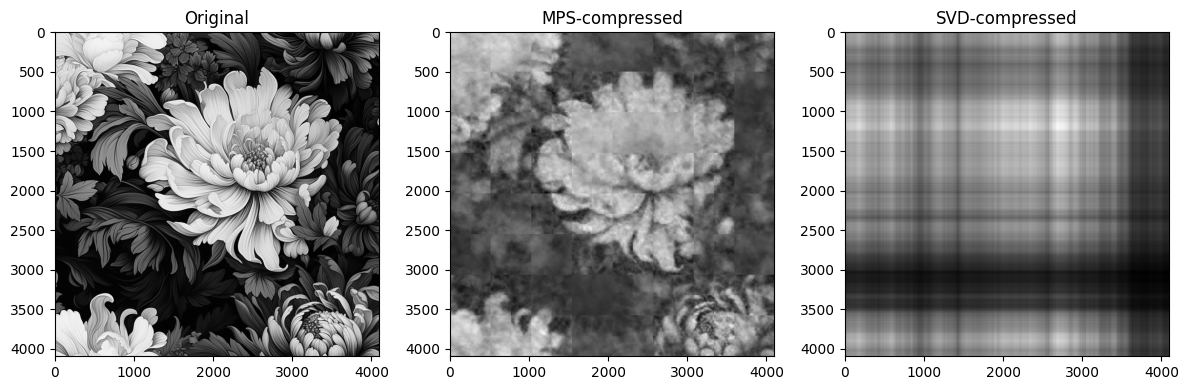

In [ ]:
# Plotting the original and MPS/SVD compressions with the same number of parameters
plt.figure(figsize=(12,23))
plt.subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.title("Original")
plt.subplot(1,3,2)
plt.imshow(img_c,cmap='gray')
plt.title("MPS-compressed")
plt.subplot(1,3,3)
plt.imshow(img_svd,cmap='gray')
plt.title("SVD-compressed")
plt.tight_layout()
plt.show()